In [1]:
using Catlab, Catlab.CategoricalAlgebra, Catlab.Programs, Catlab.WiringDiagrams, Catlab.Graphics
using AlgebraicPetri
using AlgebraicDynamics.UWDDynam, AlgebraicDynamics.DWDDynam
using LabelledArrays
using OrdinaryDiffEq, DelayDiffEq, DifferentialEquations # This is from SciML
using Plots
using JSON: parse as parse_json

## Compartmental Covid Model
https://www.sciencedirect.com/science/article/pii/S0960077921000424

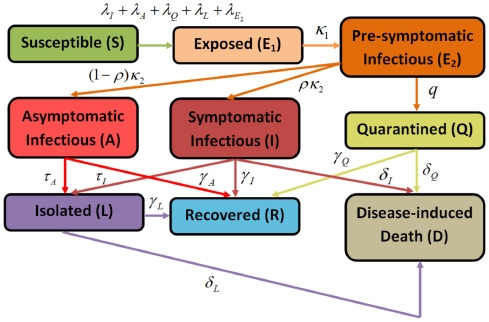

In this model, The susceptible compartment can only ever decrease in size (ignores the fact of Covid reinfection).

`Isolated = Hospitalized` Isolation separates sick people with a contagious disease from people who are not sick. Quarantine separates and restricts the movement of people who were exposed to a contagious disease to see if they become sick. Isolation is for people who are already sick.

https://www.cdc.gov/quarantine/index.html

### Next steps
These changes would be hard to do without rewriting the differential equations and recreating the.
- Allow recovered people to return to susceptible people to return to Recovered State
- Remove quarantine compartment. Exposure to Quarantine is no longer relevant.

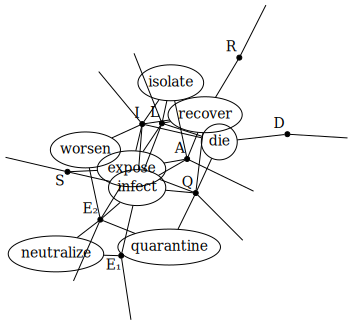

In [2]:
compartments = @relation (S, E₁, E₂,
                          I, A,  Q,
                          L, R,  D,) begin
    expose(E₂, A, I, Q, L, S)
    infect(S, E₂, A, I, Q, L, E₁)
    neutralize(E₁, E₂)
    worsen(E₂, I)
    quarantine(E₂, Q)
    isolate(A, I, L)
    recover(I, A, Q, L, R)
    die(I, L, Q, D)
    
end

display_uwd(ex) = to_graphviz(ex, box_labels=:name, junction_labels=:variable, edge_attrs=Dict(:len=>".75"));

display_uwd(compartments)

In [3]:
λ = function(βₓ, m, ζ, compartment, total_population)
    coefficient = βₓ * (1 - m*ζ)
    ratio = compartment/total_population
    coefficient * ratio
end

prefillλ = function(m, ζ, total_population)
   (βₓ, compartment) -> λ(βₓ, m, ζ, compartment, total_population)
end

dSdt = function(u,p,t)
  (E₂, A, I, Q, L, S) = u
  (;βI, βA, βQ, βL, βE₂, m, ζ) = p
  genλ = prefillλ(m, ζ, sum(x))
  λE₂, λA, λI, λQ, λL = [ genλ(β, compartment) for (β, compartment) in [
    (βE₂,E₂), (βA, A), (βI, I), (βQ, Q), (βL,L)          
  ]]
  -(λE₂ + λA + λI + λQ + λL) * S
end
susceptible = ContinuousResourceSharer{Float64}(6,dSdt)

dE₁dt = function(u,p,t)
  (S, E₂, A, I, Q, L, E₁) = u
  (;βI, βA, βQ, βL, βE₂, m, ζ, κ₁) = p
  genλ = prefillλ(m, ζ, sum(x))
  λE₂, λA, λI, λQ, λL = [ genλ(β, compartment) for (β, compartment) in [
    (βE₂,E₂), (βA, A), (βI, I), (βQ, Q), (βL,L)          
  ]]
  (λE₂ + λA + λI + λQ + λL)*S - κ₁*E₁
end
exposed = ContinuousResourceSharer{Float64}(7, dE₁dt)

dE₂dt = function(u,p,t)
  (E₁,E₂) = u
  (;κ₁,κ₂,q) = p
  κ₁*E₁ - (κ₂ + q)*E₂
end
presymptomatic = ContinuousResourceSharer{Float64}(2, dE₂dt)

dIdt = function(u,p,t)
  (E₂,I) = u
  (;ρ, κ₂, τI, γI, δI) = p
  ρ*κ₂*E₂ − (τI + γI + δI)*I
end
symptomatic = ContinuousResourceSharer{Float64}(2, dIdt)

dAdt = function(u,p,t)
  (E₂,A) = u
  (;ρ, κ₂, τA, γA) = p
  (1 − ρ)*κ₂*E₂ − (τA + γA)*A
end
asymptomatic = ContinuousResourceSharer{Float64}(2, dAdt)

dQdt = function(u,p,t)
  (E₂,Q) = u
  (;q, γQ, δQ) = p
  q*E₂ − (γQ + δQ)*Q
end
quarantined = ContinuousResourceSharer{Float64}(3, dQdt)

dLdt = function(u,p,t)
  (A, I, L) = u
  (;τI, τA, γL, δL) = p
  τI*I + τA*A − (δL + γL)*L
end
isolated = ContinuousResourceSharer{Float64}(5, dLdt)

dRdt = function(u,p,t)
  (I, A, Q, L, R) = u
  (;γI, γA, γQ, γL) = p
  γI*I + γA*A + γQ*Q + γL*L
end
recovered = ContinuousResourceSharer{Float64}(4, dRdt)

dDdt = function(u,p,t)
  (I, L, Q, D) = u
  (;δI, δL, δQ) = p
  δI*I + δL*L + δQ*Q
end
death = ContinuousResourceSharer{Float64}(4, dDdt)

ContinuousResourceSharer(ℝ^4 → ℝ^4) with 4 exposed ports

In [4]:
compartmental_system = oapply(compartments, [
    susceptible, exposed, presymptomatic, symptomatic, asymptomatic, quarantined, isolated, recovered, death
])

LoadError: Legs Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}[FinFunction([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], 35, 35), FinFunction([3, 5, 4, 6, 7, 1, 1, 3, 5, 4, 6, 7, 2, 2, 3, 3, 4, 3, 6, 5, 4, 7, 4, 5, 6, 7, 8, 4, 7, 6, 9], 31, 9)] do not have common domain

In [5]:
pops = open(parse_json, "../../configs/population.json")
state = Vector{Float64}([
    pops["susceptible"],
    pops["exposed"],
    pops["presymptomatic"],
    pops["symptomatic_infected"],
    pops["asymptomatic_infected"],
    pops["quarantined"],
    pops["isolated"],
    pops["recovered"],
    pops["death"],
  ])


params = open(parse_json, "../../configs/params.json")
parameters = LVector(
    βI = params["βI"],
    βA = params["βA"],
    βQ = params["βQ"],
    βL = params["βL"], 
    βE₂ = params["βE₂"], 
    m = params["m"],
    ζ = params["ζ"],
    κ₁ = params["κ₁"], 
    κ₂ = params["κ₂"], 
    ρ = params["ρ"],
    q = params["q"],
    τI = params["τI"],
    τA = params["τA"],
    γI = params["γI"],
    γA = params["γA"],
    γQ = params["γQ"],
    γL = params["γL"],
    δI = params["δI"],
    δL = params["δL"],
    δQ = params["δQ"],
  )

tspan = (0.0, 365.0)

(0.0, 365.0)

In [6]:
prob = ODEProblem(compartmental_system, state, tspan, parameters)
sol = solve(prob, Tsit5());

LoadError: UndefVarError: compartmental_system not defined

In [7]:
?pass

search: typeassert parse_json_sexpr parse_json_acset parse_json_graph

Couldn't find pass
Perhaps you meant parse, parts, pairs, pair, pops, Base, ans, last, less or abs


No documentation found.

Binding `pass` does not exist.


In [8]:
solve_day = (day) -> last(
    solve(
      ODEProblem(compartmental_system, state, (day-1, day), parameters),
      Tsit5()
    ).u
)

solve_day(5)

LoadError: UndefVarError: compartmental_system not defined

In [9]:
?ContinuousResourceSharer

search: ContinuousResourceSharer



```
ContinuousResourceSharer{T}(nports, nstates, f, portmap)
```

An undirected open continuous system. The dynamics function `f` defines an ODE $\dot u(t) = f(u(t),p,t)$.
